Código para Dataset de Circulación

In [90]:
# Importamos librerias:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
# Leemos los dataset
serie_v = pd.read_csv("/content/covid_total_diario.csv", sep=";", index_col= "fecha")
serie_v.index = pd.to_datetime(serie_v.index, format= "%d/%m/%Y")

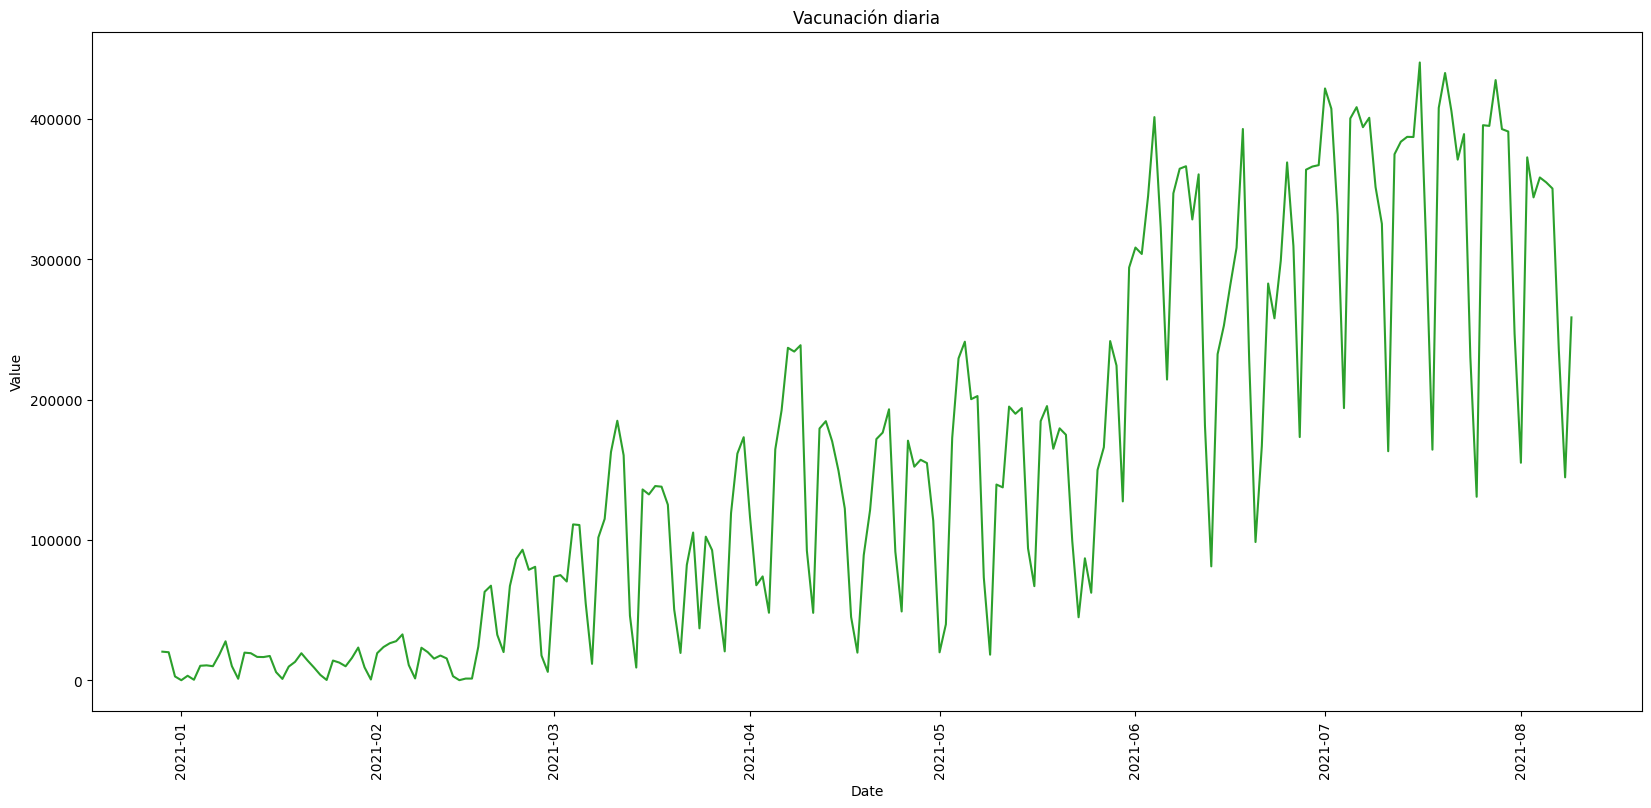

In [92]:
# Gráfico vacunas
def plot_data(data, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(20,9), dpi=dpi)
    plt.plot(x, y, color='tab:green')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.xticks(rotation=90)
    plt.savefig("Image.png")
    plt.show()
plot_data(serie_v, x=serie_v.index, y=serie_v.total_1ra_y_2da_dosis_aplicadas, title='Vacunación diaria')

In [93]:
# Agregamos días de la semana:
serie_v['Weekday'] = pd.DatetimeIndex(serie_v.index).to_series().dt.day_name()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



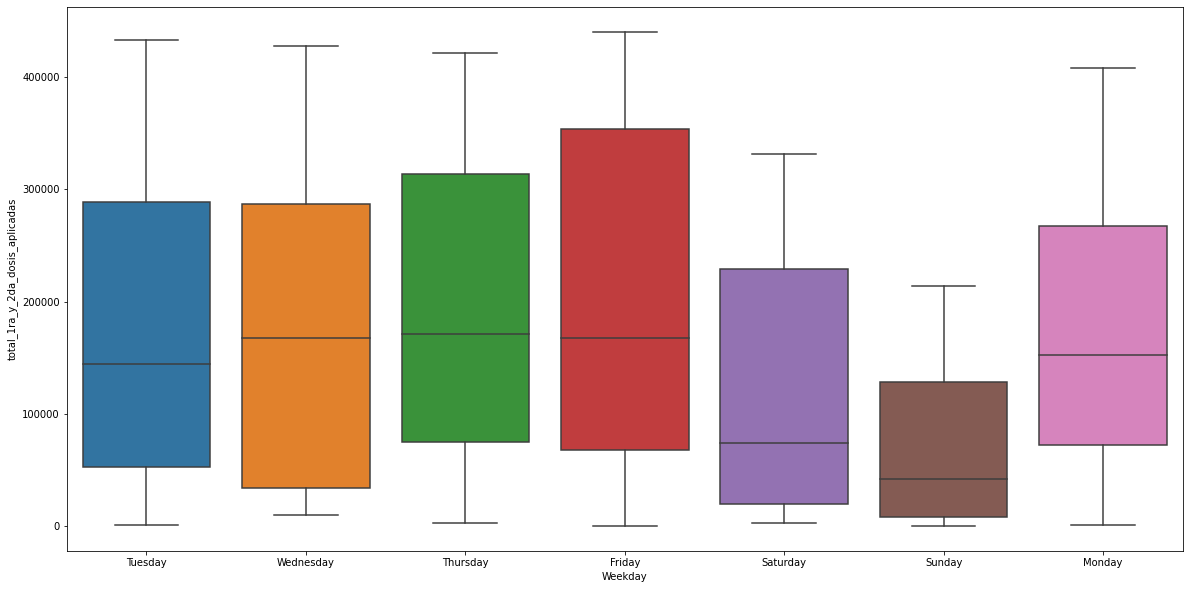

In [94]:
# Graficamos boxplot:
import seaborn
fig, ax = plt.subplots(figsize=(20,10))
seaborn.boxplot(serie_v.Weekday, serie_v.total_1ra_y_2da_dosis_aplicadas, ax=ax)
plt.savefig("boxplot.png")

In [95]:
# Conviertimos en array para realizar tests de estacionariedad
serie_v = serie_v.drop(labels="Weekday", axis=1)
serie_v_array = serie_v.loc[:, 'total_1ra_y_2da_dosis_aplicadas'].values

In [96]:
# Test KPSS para driving:
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, regression="c")
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(serie_v_array)

KPSS Statistic: 1.370371536788803
p-value: 0.01
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is smaller than the indicated p-value



In [97]:
# Test ADF:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    for key, value in result[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] > 0.05 else ""}stationary')   

In [98]:
adf_test(serie_v_array)

ADF Statistic: -1.187966412153414
p-value: 0.6787507180581169
Critial Values:
   1%, -3.4620315036789666
Critial Values:
   5%, -2.8754705024827127
Critial Values:
   10%, -2.5741950726860647
Result: The series is not stationary


In [99]:
# Instalo librerias:
!pip install chart-studio

In [100]:
from chart_studio import plotly
from statsmodels.tsa.seasonal import seasonal_decompose

In [101]:
import plotly.express as px

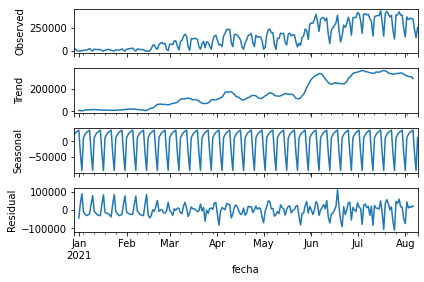

In [102]:
# Graficamos descomposición de serie:
result = seasonal_decompose(serie_v, model="additive")
fig = result.plot()
plt.savefig("Image 3.c.png")
plt.show(fig)

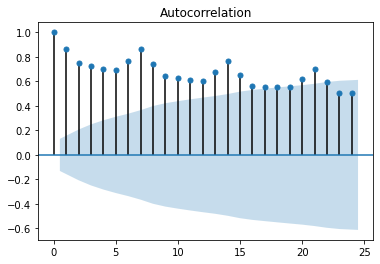

In [103]:
# Gráfico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_v)
plt.savefig("Image 3.d.png")
plt.show()

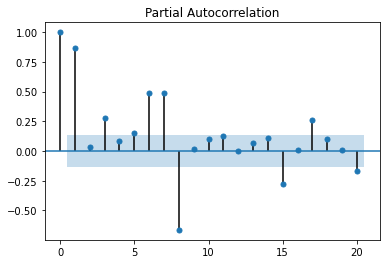

In [104]:
# Gráfico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_v, lags=20)
plt.savefig("Image 3.e.png")
plt.show()

In [105]:
# Realizamos test Ljung-Box con lag=20
import statsmodels.api as sm
sm.stats.acorr_ljungbox(serie_v, lags=20)

# P valor para todos los lags es meor a 0,05, por lo tanto rejecteamos la H0 -> Hay al menos una correlacion distinta de 0

(array([ 168.30208502,  296.50642555,  415.79794851,  528.99890418,
         639.1006979 ,  776.32943624,  950.54470463, 1079.41812462,
        1177.69673479, 1270.03311983, 1358.74138459, 1444.43476856,
        1554.27454474, 1695.15193055, 1797.41945253, 1874.63985766,
        1950.48781997, 2026.07651176, 2100.93763904, 2197.02982245]),
 array([1.73787570e-038, 4.11573845e-065, 8.37615419e-090, 3.57611206e-113,
        7.18218397e-136, 2.00191043e-164, 5.81976973e-201, 1.06678417e-227,
        7.91326877e-248, 1.12067845e-266, 9.58435736e-285, 3.64877124e-302,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

In [106]:
# Diferenciamos la serie:

serie_v_dif=serie_v
serie_v_dif["Diferences"] = None


In [107]:
for i in range(0,(serie_v_dif.shape[0]-1)):
  serie_v_dif.iloc[(i+1),1]=serie_v_dif.iloc[(i+1),0] - serie_v_dif.iloc[i,0]

In [108]:
serie_v_dif.head()

,total_1ra_y_2da_dosis_aplicadas,Diferences
fecha,,
2020-12-29,20455,None
2020-12-30,20050,-405
2020-12-31,2805,-17245
2021-01-01,121,-2684
2021-01-02,3288,3167


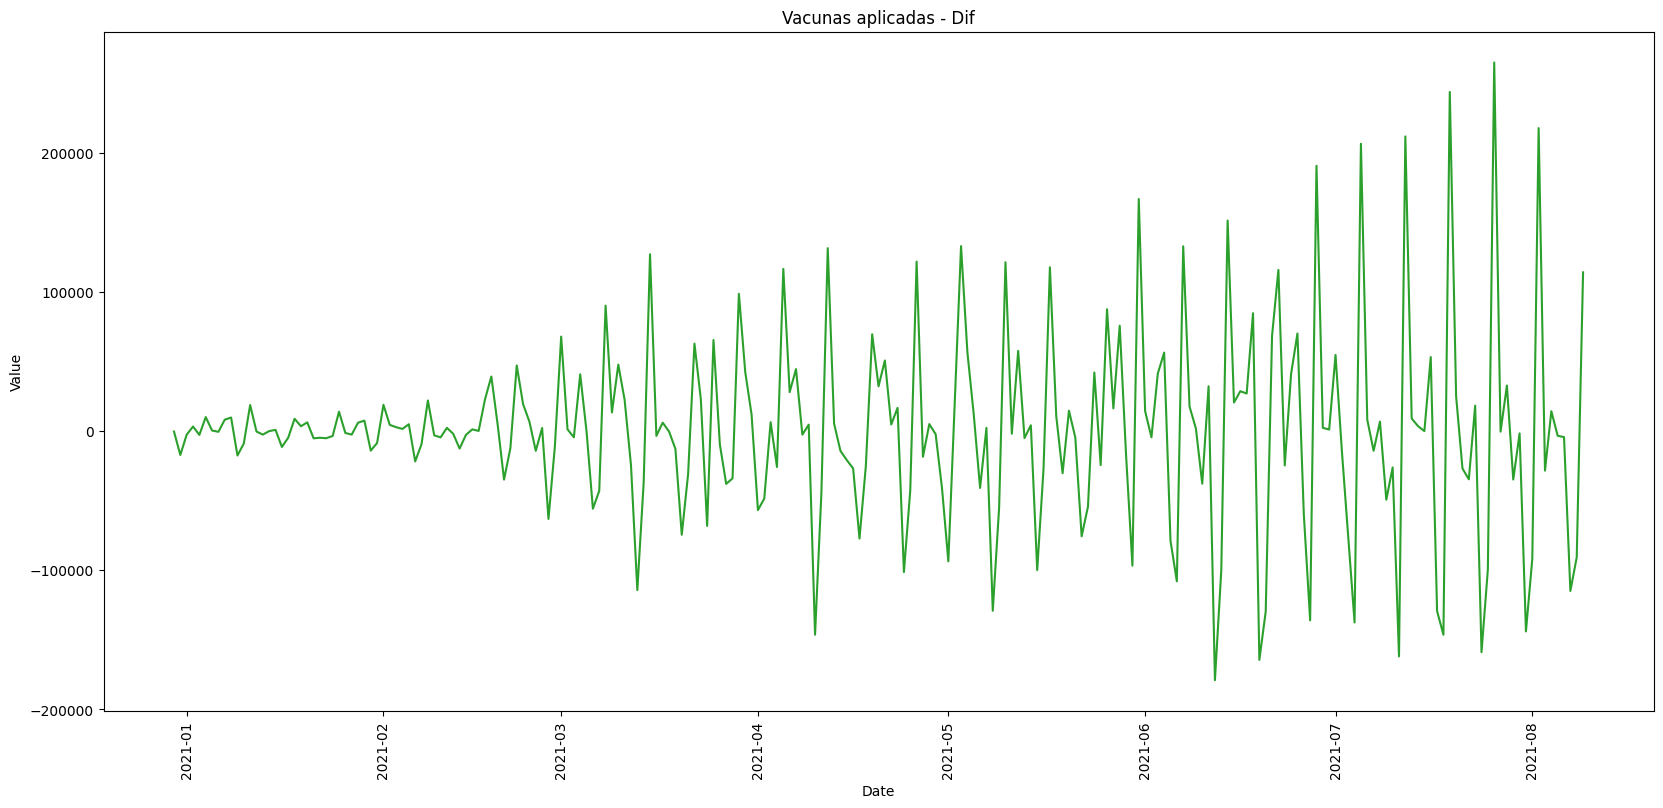

In [109]:
# Graficamos la serie diferenciada:
plot_data(serie_v_dif, x=serie_v_dif.index, y=serie_v_dif.Diferences, title='Vacunas aplicadas - Dif')

In [110]:
# Convertimos en array para realizar tests de estacionariedad
serie_v_dif_array = serie_v_dif.iloc[1:, 1].values

In [111]:
# Test KPSS
kpss_test(serie_v_dif_array)

KPSS Statistic: 0.042754807605155876
p-value: 0.1
num lags: 15
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning:

The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning:

p-value is greater than the indicated p-value



In [112]:
# Test ADF
adf_test(serie_v_dif_array)

ADF Statistic: -4.835554993130046
p-value: 4.647903137820063e-05
Critial Values:
   1%, -3.4623415245233145
Critial Values:
   5%, -2.875606128263243
Critial Values:
   10%, -2.574267439846904
Result: The series is stationary


In [113]:
serie_v_dif=serie_v_dif["Diferences"].iloc[1:]
serie_v_dif=pd.DataFrame(serie_v_dif)

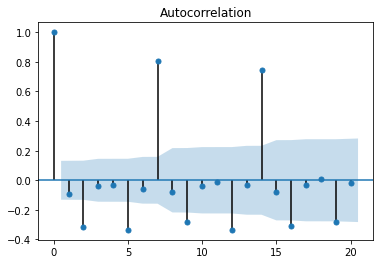

In [117]:
# Grafico de ACF
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(serie_v_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 6.b.png")
plt.show()

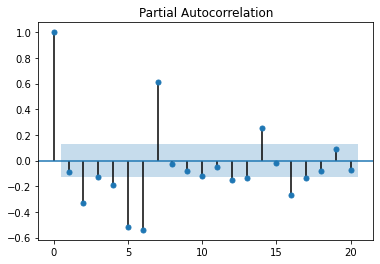

In [118]:
# Grafico de PACF
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(serie_v_dif.Diferences.tolist(), lags=20)
plt.savefig("Image 6.c.png")
plt.show()

In [116]:
# Test de Ljung Box:
sm.stats.acorr_ljungbox(serie_v_dif.Diferences.tolist(), lags=20)

(array([  1.90885906,  24.85372699,  25.23321161,  25.49310505,
         51.00645141,  51.83907094, 201.51542704, 203.00724368,
        221.65682785, 222.04084202, 222.06435037, 248.81266707,
        249.07147346, 383.32712904, 384.85192566, 407.50987006,
        407.73486188, 407.74441994, 427.58666793, 427.65759416]),
 array([1.67090052e-01, 4.00942188e-06, 1.38004181e-05, 4.00346809e-05,
        8.62245147e-10, 2.00905947e-09, 5.48153309e-40, 1.48500637e-39,
        9.38151537e-43, 3.99605482e-42, 1.91779071e-41, 2.41942678e-46,
        9.98079704e-46, 4.10406784e-73, 1.04927680e-72, 9.70034692e-77,
        4.47310725e-76, 2.21852090e-75, 7.88142512e-79, 3.67070108e-78]))